## Tests for *fpcross* module

> Cross approximation of the solution of the Fokker-Planck equation.

In [1]:
import sys
import time

import numpy as np
from numpy import kron as kron

import scipy.sparse as sp
from scipy.linalg import expm as expm
from scipy.interpolate import RectBivariateSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML

sys.path.append('./../lib')
from intertrain import Intertrain

---
---

### Algorithm

**Задача:** найти PDF $\rho$ в момент времени $t$ на Чебышевской сетке из уравнений
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x).
$$

**Нужно** передать в крест функцию (step), которая вычисляет значения $\rho_{k+1}$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки. Это позволит проинтерполировать $\rho$ на $(k+1)$-ом шаге и перейти к следующему шагу. При этом предполагается, что интерполянт для $k$-ого шага уже известен.

> **На каждом шаге будем вычислять и интерполировать $\log{\rho}$.**

> На нулевом шаге имеем $\rho_0(x)$, заданную как функцию от $x$ и можем построить интерполянт очевидным образом.

> Если не используем крест (работаем в полном numpy формате), то $X$ - это полный набор точек Чебышевской сетки (алгоритм при этом остается прежним).

> Алгоритм расписан для splitting схемы первого порядка, поэтому для решения ОДЕ можем использовать метод Эйлера без потери точности.

**Работа функции step(X, I)**

> X - произвольный набор точек Чебышевской сетки (ndarray [dims, pois] of float)

> I - набор индексов узлов сетки, соответствующий точкам X (ndarray [dims, pois] of int)

**1** Найти прообразы $\widehat{X}$ (соответствуют предыдущему $k$-ому шагу) для заданного набора точек $X$ Чебышевской сетки, которые приводили бы траекторию детерминированного уравнения ($\beta = 0$) в точки $X$ на $(k+1)$-ом шаге, интегрируя назад уравнение
$$
    \frac{\partial \, x}{\partial \, t} = f(x, t),
    \quad
    x_{k+1} = X,
    \quad
    x_{k} = \widehat{X} = ?.
$$

**2** Используя известный интерполянт на $k$-ом шаге, вычислить значения логарифма PDF $\log{\widehat{\rho}}$ в точках $\widehat{X}$.

**3** Положить нулевое значение для $\log{\widehat{\rho}}$ в тех точках из $\widehat{X}$, которые оказались вне пределов интерполяции.

**4** Решить ODE для $k+1$-ого шага
$$
    \frac{\partial \, \log{w}}{\partial \, t} = -tr \left[ f_x(x, t) \right],
    \quad
    \log{w_{k}} = \log{\widehat{\rho}},
    \quad
    \log{w_{k+1}} = \log{w} = ?,
$$
используя формулу Эйлера
$$
    \log{w} = \log{\widehat{\rho}} - h \cdot tr \left[ f_x(x_k, t_k) \right].
$$

**5** Решить PDE с однородными граничными условиями Дирихле для $(k+1)$-ого шага
$$
    \frac{\partial v}{\partial t} = \Delta v,
    \quad
    v_{k} = e^{\log{w_{k}}},
    \quad
    v_{k+1} = v = ?,
$$
используя дифференциальную матрицу Чебышева
$$
v = e^h \left( e^D \otimes \ldots \otimes e^D \right) e^{\log{w_{k}}},
$$

**6** Вычислить значение $\log{v}$.

**7** Вернуть значение $\log{v}$ как приближение $\log{\rho(x)}$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки на $(k+1)$-ом шаге.

In [2]:
class Solver(object):
    
    def __init__(self):
        '''
        Init main parameters.
        '''
        
        self.IT = Intertrain(           # Current interpolant
            n=[n], l=[l], with_tt=False
        ) 
        self.IT0 = None                 # Interpolant from previous step
        self.IT1 = None                 # Initial interpolant
        self.IT2 = None                 # Final interpolant
    
        self.I = np.eye(n)
        
        self.J = np.eye(n)
        self.J[0, 0] = 0.
        self.J[-1, -1] = 0.
        
        self.D = self.IT.dif2()
        self.D = self.J@self.D
        self.Z = np.exp(h) * expm(self.D)

    def step(self, X, I):
        '''
        One time step.
        '''
        print('--- Step')
        X0 = X - h * func_f(X)
        I1 = X0 < -3. # TODO! replace by real x_lim
        I2 = X0 > +3. # TODO! replace by real x_lim
        
        print('X: ', X)
        print('X0: ', X0)
        
        r0_log = self.IT0.calc(X0)
        r0_log[I1.reshape(-1)] = 0.
        r0_log[I2.reshape(-1)] = 0.
        print('r0_log: ', r0_log)
        
        w_log = r0_log - h * np.trace(func_f_der(X))
        w = np.exp(w_log)
        print('w_log: ', w_log)
        print('w: ', w)
        
        #w = w.reshape(-1)[1:-1]
        
        
        v = self.Z@self.J@w
        print('v: ', v)
        
        #vv = r0_log.copy()
        #vv[0] = 0.
        #vv[-1] = 0.
        #vv[1:-1] = v[:]

        r_log = np.log(v)
        print('r_log: ', r_log)
        
        return r_log
  
    def step_dif(self, X, I):
        '''
        One time step for diffusion.
        '''
        print('--- Step')
        X0 = X - h * func_f(X)
        I1 = X0 < -3. # TODO! replace by real x_lim
        I2 = X0 > +3. # TODO! replace by real x_lim
        
        print('X: ', X)
        print('X0: ', X0)
        
        r0 = self.IT0.calc(X0)
        r = self.Z@r0
        return r
    
    def calc(self):
        '''
        Run calculations.
        '''
        
        self.IT.init(lambda x: np.log(func_r0(x))).prep()
        self.IT1 = self.IT.copy()

        for t in T:
            self.IT0 = self.IT.copy()
            self.IT.init(self.step, opts={'is_f_with_i': True}).prep()

        self.IT2 = self.IT.copy()

---
---

### Solution of 1D Ornstein–Uhlenbeck process

Ornstein–Uhlenbeck process
$$
    \frac{d \, x}{d \, t} = - \lambda x(t) + w(t),
    \quad
    x(0) = x_0,
    \quad
    \lambda > 0,
$$
or
$$
    d \, x = - \lambda x(t) d \, t + d \, \beta(t),
    \quad
    x(0) = x_0,
    \quad
    \lambda > 0,
$$

Its solution is
$$
    x(t) = e^{-\lambda t} x(0) + \int_0^t e^{-\lambda (t - \tau)} d \, \beta(\tau),
$$
and covariance matrix is
$$
    C(t) = \frac{q}{2\lambda} e^{-\lambda |t|},
$$
where $q$ is spectral density of the one dimensional white noise process $w(t)$.

The probability density function (PDF) $\rho(x, t)$ satisfies the Fokker–Planck equation
$$
   \frac{\partial \, \rho}{\partial \, t} =
       \lambda \frac{\partial}{\partial \, x} (x \rho) +
       \frac{1}{2} \frac{\partial^2 \, \rho}{\partial \, x^2},
$$
with transition probability
$$
    \rho(x, t | x_0, t_0=0) = 
        \sqrt{
            \frac{\lambda}{\pi \left( 1 - e^{-2 \lambda t} \right)}
        }
        e^{\frac
            {-\lambda \left( x - x_0 e^{-\lambda t} \right)^2}
            {1 - e^{-2 \lambda t}}
        }.
$$

In [3]:
# SDE parameters : f = A x, df / dx = A (dimension = 1)

A = -1.

def func_f(x):
    return np.zeros(x.shape)

    return A*x

def func_f_der(x):
    return np.zeros(x.shape)

    if not isinstance(x, np.ndarray):
        return A
    return A*np.ones(x.shape)

def func_r0(x):
    s = 1.
    m = 0.
    r = 1./np.sqrt(2.*np.pi * s**2)
    r*= np.exp(-1. * (x-m)**2 / 2. / s**2)
    return r.reshape(-1)
    # return np.exp(-0.5 * np.diag(x.T@x))

def func_r_trans(x, t, x0):
    l = -1. * A
    e = np.exp(-1. * l * t)
    r = np.sqrt(l / np.pi /  (1. - e*e))
    r*= np.exp(-1. * l * (x - x0 * e)**2 / (1. - e*e))
    return r

In [12]:
# Time grid

t_min = 0.
t_max = 1.
t_poi = 2 # including t_min and t_max (>= 2)

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(t_min, t_max, t_poi)

In [13]:
# Spatial grid

n = 10
l = [-3., 3.]

In [14]:
# Run calculations

SL = Solver()
SL.calc()

--- Step
X:  [[ 3.          2.81907786  2.29813333  1.5         0.52094453 -0.52094453
  -1.5        -2.29813333 -2.81907786 -3.        ]]
X0:  [[ 3.          2.81907786  2.29813333  1.5         0.52094453 -0.52094453
  -1.5        -2.29813333 -2.81907786 -3.        ]]
r0_log:  [-5.41893853 -4.89253853 -3.55964693 -2.04393853 -1.05463014 -1.05463014
 -2.04393853 -3.55964693 -4.89253853 -5.41893853]
w_log:  [-5.41893853 -4.89253853 -3.55964693 -2.04393853 -1.05463014 -1.05463014
 -2.04393853 -3.55964693 -4.89253853 -5.41893853]
w:  [0.00443185 0.00750235 0.02844887 0.1295176  0.34832123 0.34832123
 0.1295176  0.02844887 0.00750235 0.00443185]
v:  [-8.51961182e-16  6.34012530e-03  2.40818859e-02  4.73960518e-02
  6.45500712e-02  6.45500712e-02  4.73960518e-02  2.40818859e-02
  6.34012530e-03  0.00000000e+00]
r_log:  [        nan -5.06085675 -3.72629534 -3.04921635 -2.74031406 -2.74031406
 -3.04921635 -3.72629534 -5.06085675        -inf]
--- Step
X:  [[ 3.          2.81907786  2.29813333 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log


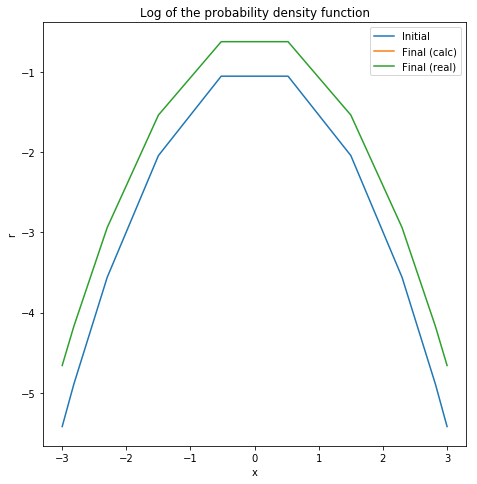

In [8]:
# Plot distribution (initial and final) on the spatial grid

fig = plt.figure(figsize=(6, 6))
gs = mpl.gridspec.GridSpec(
    ncols=1, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1], height_ratios=[1]
)

Xg = SL.IT.grid()
x0 = Xg.reshape(-1)
r1 = SL.IT1.calc(Xg).reshape(-1)
r2 = SL.IT2.calc(Xg).reshape(-1)
rr = np.log(func_r_trans(Xg, T[-1], Xg)).reshape(-1)
ax = fig.add_subplot(gs[0, 0])
ax.plot(x0, r1, label='Initial')
ax.plot(x0, r2, label='Final (calc)')
ax.plot(x0, rr, label='Final (real)')
ax.set_title('Log of the probability density function')
ax.set_xlabel('x')
ax.set_ylabel('r')
ax.legend(loc='best')

plt.show()

---
---

### TMP

In [20]:
np.linalg.eigvals(SL.D)

array([ 0.05648125+0.04111301j,  0.05648125-0.04111301j,
        0.04938681+0.j        , -0.02164712+0.06629694j,
       -0.02164712-0.06629694j,  0.01500226+0.04688603j,
        0.01500226-0.04688603j, -0.03969566+0.02867128j,
       -0.03969566-0.02867128j, -0.06966827+0.j        ])

In [21]:
np.linalg.eigvals(SL.Z)

array([2.93887386+0.j        , 2.27812992+1.30571227j,
       2.27812992-1.30571227j, 1.00776374+1.52030831j,
       1.00776374-1.52030831j, 0.27585279+0.95439386j,
       0.27585279-0.95439386j, 0.15777662+0.35077197j,
       0.15777662-0.35077197j, 0.16233784+0.j        ])

In [ ]:
def solve_ode_r(func, x0, r0, h):
    '''
    Solve d(log r)/dt = -tr(f(x, t)), r(t0, x) = r0(x) for t = t0 + h.
    '''
    
    f = -1. * np.trace(func(x0))
    
    #r = (1. - h * np.trace(f)) * r0
    #r = (1. - h * f) * r0
    #return r
    
    # r_log = np.log(r0) + h * f
    # r = np.exp(r_log)
    
    r_log = r0 + h * f
    
    return r_log

def solve_ode_x(func, x0, h):
    '''
    Solve dx/dt = f(x, t), x(t0) = x0 for t = t0 + h.
    '''
    
    f = func(x0)
    x = x0 + h * f
    
    return x

def solve_pde_r(r0, Z):
    '''
    Solve d(r)/dt = d2 r / d x2, r(t0, x) = r0(x) (BC is zero) for t = t0 + h.
    '''
    
    return Z@r0